## BYOL for image segmentation

Example with UNet model from [segmentation-models-pytorch](https://github.com/qubvel/segmentation_models.pytorch/tree/master).

In [1]:
import sys

sys.path.append("./../")

from byol.models import BYOL, UNETModule
from byol.utils import BYOLTransforms1, BYOLTransforms
import torch
import pytorch_lightning as pl
import torchvision
import numpy as np

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

/home/rafael/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset
import os
from torch.utils.data import DataLoader

root = "."
SimpleOxfordPetDataset.download(root)
# init train, val, test sets
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 3312
Valid size: 368
Test size: 3669


### Training an UNET model on the SimpleOxfordPet Dataset

In [3]:
unet_module = UNETModule()

unet_trainer = pl.Trainer(
    max_epochs=1,
    accelerator=accelerator,
    devices=1,
)

unet_trainer.fit(unet_module, train_dataloader, valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-02-24 20:25:22.541163: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 20:25:22.600163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 20:25:23.444686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------

Epoch 0: 100%|██████████| 207/207 [01:36<00:00,  2.15it/s, v_num=22, val_iou=0.647]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 207/207 [01:36<00:00,  2.14it/s, v_num=22, val_iou=0.647]


In [4]:
unet_trainer.test(unet_module, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 230/230 [00:32<00:00,  7.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │    0.6519654989242554     │
└───────────────────────────┴───────────────────────────┘

[{'test_iou': 0.6519654989242554}]

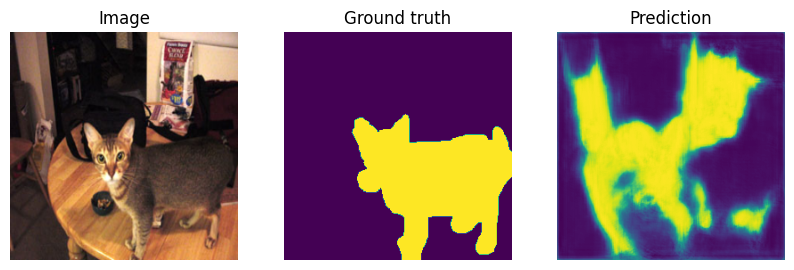

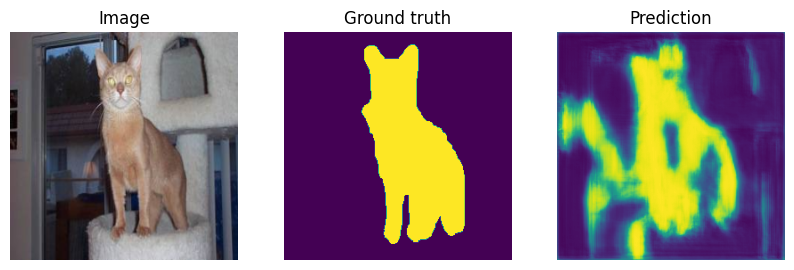

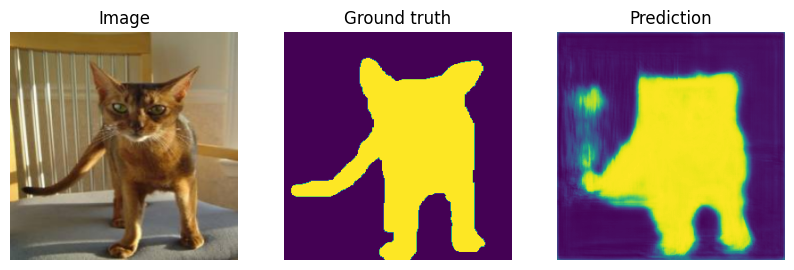

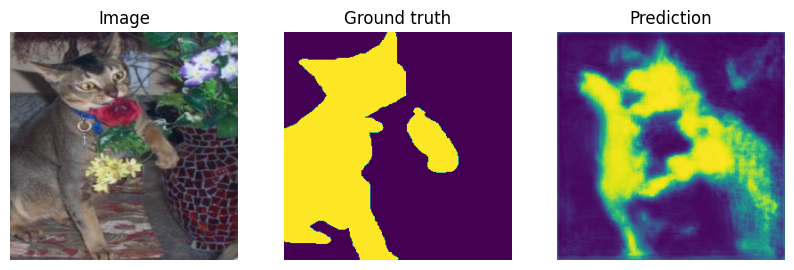

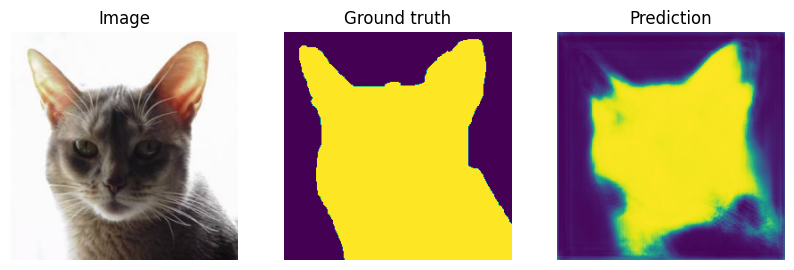

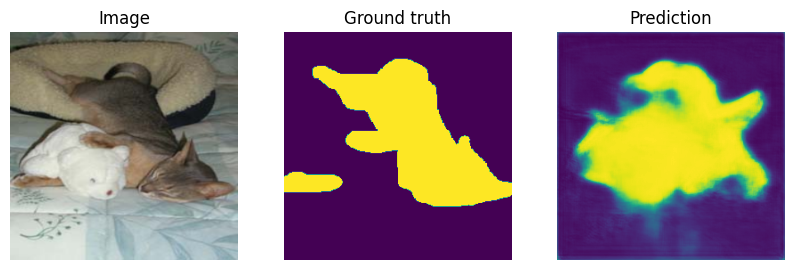

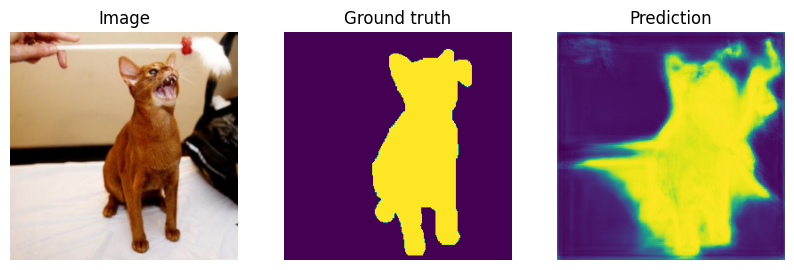

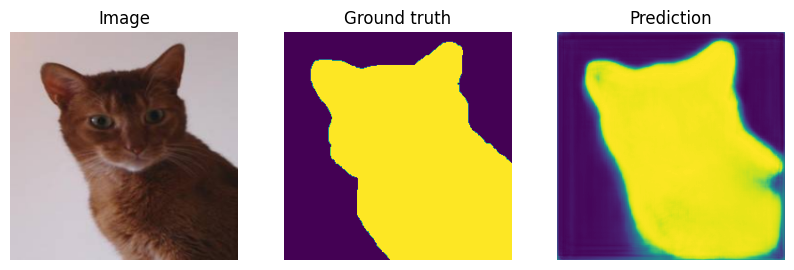

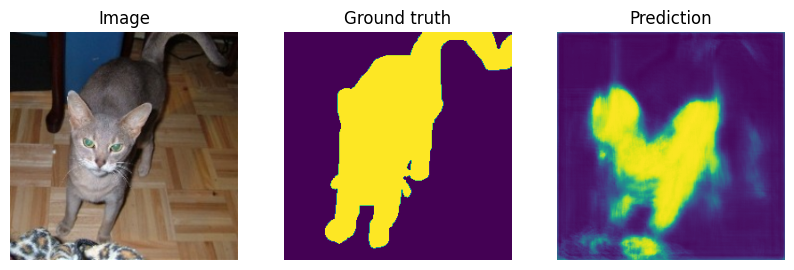

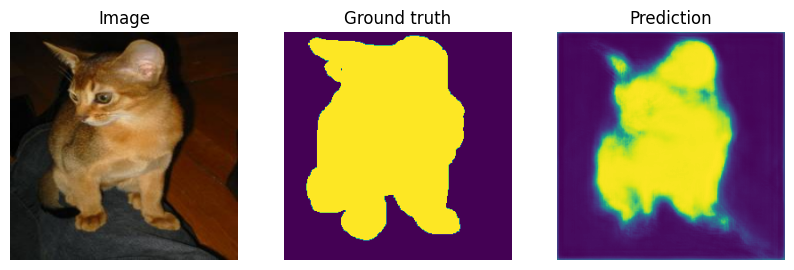

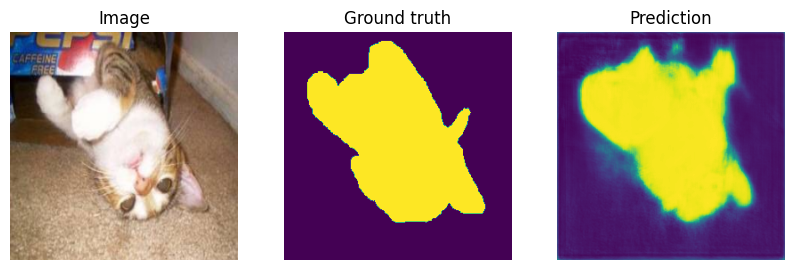

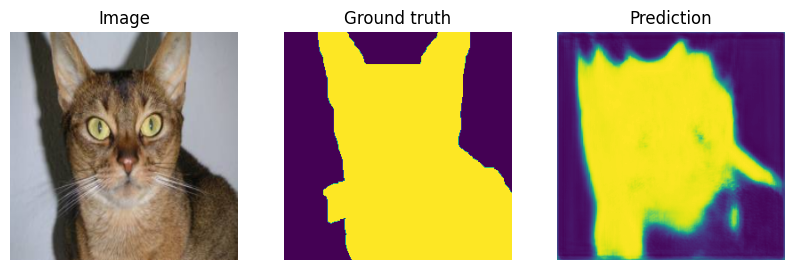

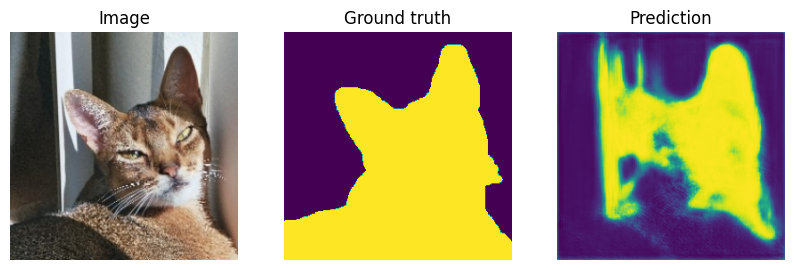

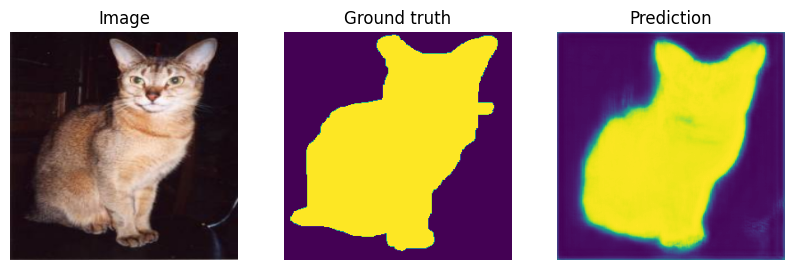

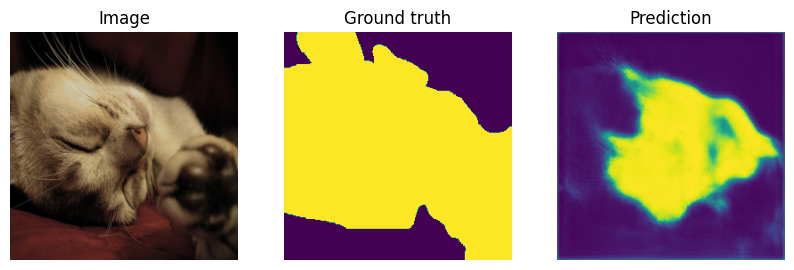

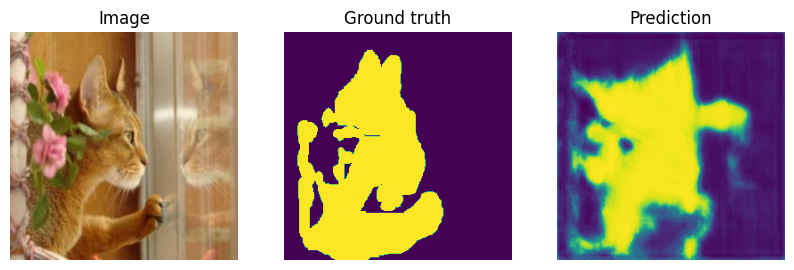

In [5]:
import matplotlib.pyplot as plt

batch = next(iter(test_dataloader))
with torch.no_grad():
    unet_module.eval()
    logits = unet_module(batch["image"].float())
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
     

### Training BYOL on SimpleOxfordPet Dataset

In [6]:
test_dataset

In [7]:
transform = BYOLTransforms(
    view1=BYOLTransforms1(input_size=256),
    view2=BYOLTransforms1(input_size=256)
)

byol_dataset = SimpleOxfordPetDataset(root, "test", transform=transform)

byol_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True, num_workers=n_cpu)
byol_module = BYOL(
    model=unet_module.model,
    batch_type="dict",
)

byol_trainer = pl.Trainer(
    max_epochs=3,
    devices=1,
    accelerator=accelerator,
)

byol_trainer.fit(model=byol_module, train_dataloaders=byol_dataloader) # our model never sees labeled data!



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type               | Params
--------------------------------------------------------------
0 | backbone               | Unet               | 14.3 M
1 | projection_head        | BYOLProjectionHead | 788 K 
2 | prediction_head        | BYOLPredictionHead | 526 K 
3 | target_projection_head | BYOLProjectionHead | 788 K 
4 | loss                   | CosineSimilarity   | 0     
--------------------------------------------------------------
1.3 M     Trainable params
15.1 M    Non-trainable params
16.4 M    Total params
65.729    Total estimated model params size (MB)


/home/rafael/miniconda3/envs/gengar/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s] {'image': tensor([[[[100, 111, 115,  ..., 181, 182, 180],
          [113, 117, 118,  ..., 180, 184, 185],
          [115, 117, 118,  ..., 182, 184, 184],
          ...,
          [150, 150, 150,  ..., 177, 175, 174],
          [152, 152, 153,  ..., 178, 173, 172],
          [153, 151, 152,  ..., 176, 175, 174]],

         [[ 58,  64,  70,  ..., 166, 166, 166],
          [ 66,  69,  71,  ..., 166, 167, 169],
          [ 70,  75,  78,  ..., 168, 171, 172],
          ...,
          [122, 118, 120,  ..., 159, 156, 155],
          [121, 119, 121,  ..., 159, 155, 155],
          [122, 121, 121,  ..., 159, 158, 156]],

         [[ 33,  41,  42,  ..., 156, 156, 155],
          [ 41,  42,  41,  ..., 155, 158, 159],
          [ 36,  39,  40,  ..., 161, 164, 163],
          ...,
          [ 91,  90,  93,  ..., 153, 149, 147],
          [ 90,  91,  92,  ..., 152, 148, 147],
          [ 90,  91,  90,  ..., 150, 149, 147]]],


        [[[202, 202, 202, 

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same